In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import wrangle

In [2]:
zil = wrangle.acquire_zillow()

In [3]:
zil = wrangle.prepare_zillow(zil)

In [4]:
train, val, test = wrangle.split_data(zil)

(array([2.0000e+00, 0.0000e+00, 2.5000e+01, 1.0000e+02, 4.9162e+04,
        1.1700e+03, 7.3000e+01, 5.1000e+01, 1.0000e+00, 1.0000e+00]),
 array([-4.65542038, -3.66357847, -2.67173657, -1.67989467, -0.68805277,
         0.30378914,  1.29563104,  2.28747294,  3.27931484,  4.27115675,
         5.26299865]),
 <BarContainer object of 10 artists>)

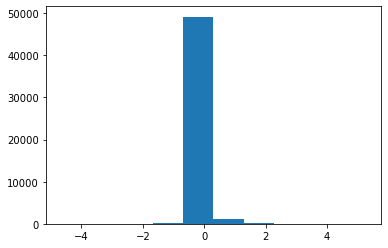

In [5]:
plt.hist(zil.logerror)

In [6]:
train.columns.tolist()

['basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'decktypeid',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'hashottuborspa',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'threequarterbathnbr',
 'yearbuilt',
 'fireplaceflag',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock',
 'logerror',
 'transactiondate',
 'typeconstructiondesc',
 'propertylandusedesc']

#### 1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

- Q1. Does county have a relationship with log error?
- Q2. Does bedroomcnt have a relationship with logerror? control for county
- Q3. Does bathroomcnt have a relationship with logerror? control for county
- Q4. Does yearbuilt have a relationship with log error? control for county
- Q5. Does tax value have a relationship with log error? control for county

#### 2. Answer those questions through a mix of statistical tests and visualizations.

##### Q1. Does zipcode have a relationship with log error? control for county

In [7]:
train = train.drop(index=train[train.regionidzip == train.regionidzip.max()].index.tolist())

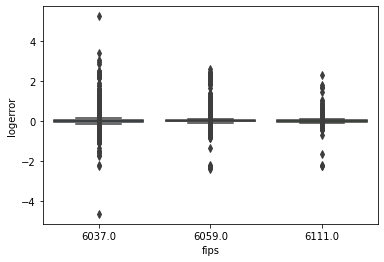

In [8]:
sns.boxplot(data=train, x='fips', y='logerror')
plt.show()

##### Q2. Does bathroomcnt have a relationship with logerror? control for county

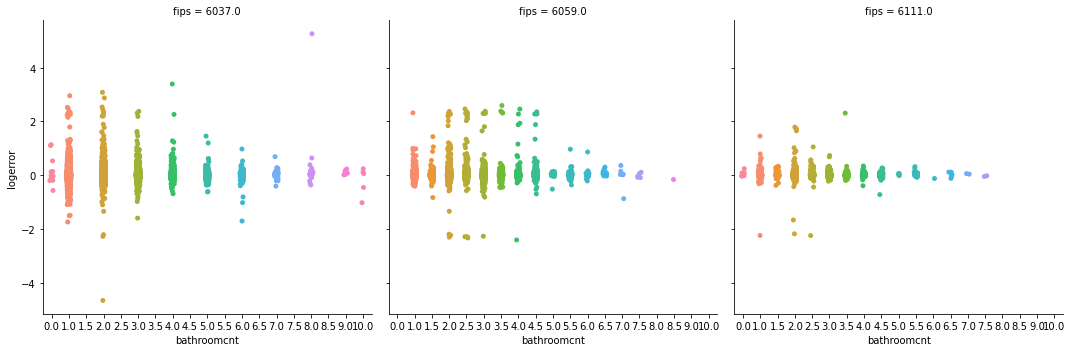

In [9]:
sns.catplot(data=train, x='bathroomcnt', y='logerror', col='fips')
plt.show()

In [28]:
# homes with above avg bathroom cnt have less log error

In [30]:
baths_above_mean = train[train.bathroomcnt > train.bathroomcnt.mean()].logerror
baths_below_mean = train[train.bathroomcnt <= train.bathroomcnt.mean()].logerror

In [32]:
α = 0.05
s,pval = stats.levene(baths_above_mean,baths_below_mean)
t,p = stats.ttest_ind(baths_above_mean,baths_below_mean,equal_var=(p>α))
t < 0, p/2 < α

(False, True)

In [33]:
# Fail to reject the null hypothesis. Homes with above avg bathroom counts do not have a lower log error mean

##### Q3. Does taxdelinquency have a relationship with logerror? control for county

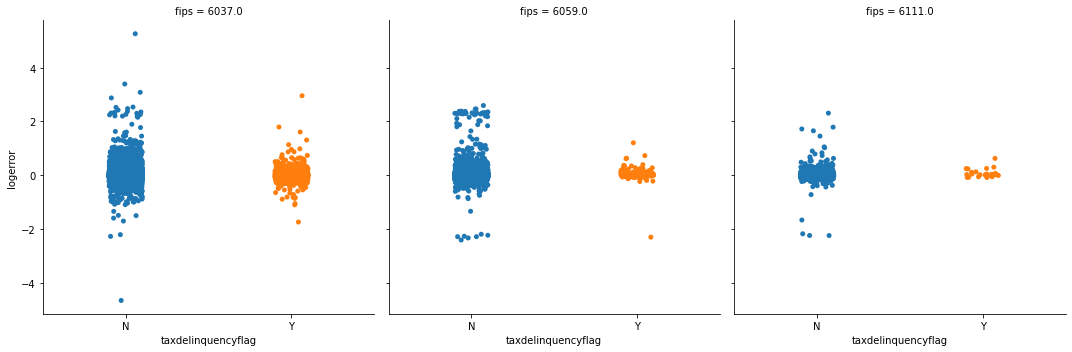

In [34]:
sns.catplot(data=train, x='taxdelinquencyflag', y='logerror', col='fips', kind='strip')
plt.show()

In [35]:
# homes with a tax deliq flag have less log error

In [38]:
tax_del_yes = train[train.taxdelinquencyflag == 'Y'].logerror
tax_del_no = train[train.taxdelinquencyflag == 'N'].logerror

In [39]:
α = 0.05
s,pval = stats.levene(tax_del_yes,tax_del_no)
t,p = stats.ttest_ind(tax_del_yes,tax_del_no,equal_var=(p>α))
t < 0, p/2 < α

(False, False)

In [41]:
# super fail to reject the null hypothesis. Probably due to size of each sample

##### Q4. Does yearbuilt have a relationship with log error? control for county

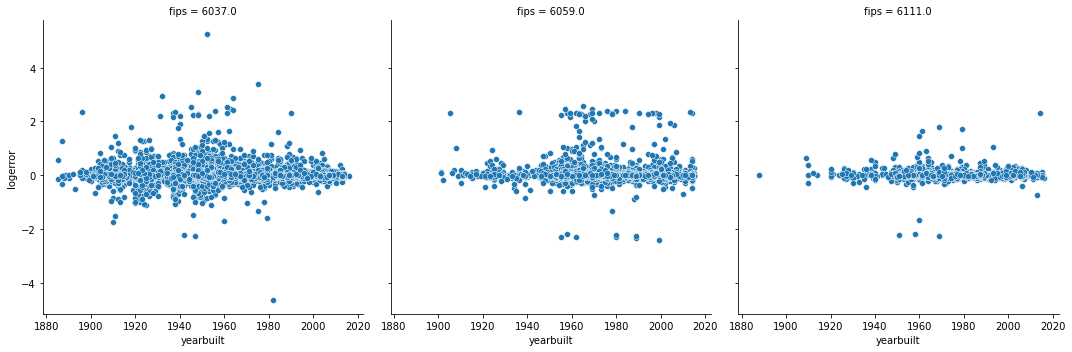

In [11]:
sns.relplot(data=train, x='yearbuilt', y='logerror', col='fips')
plt.show()

In [42]:
# there is no relationship with year built and log error

In [43]:
stats.spearmanr(train.yearbuilt, train.logerror)

SpearmanrResult(correlation=0.04591436008565727, pvalue=1.2444185660289555e-15)

In [45]:
# not correlated even with low p val.

##### Q5. Does tax value have a relationship with log error? control for county

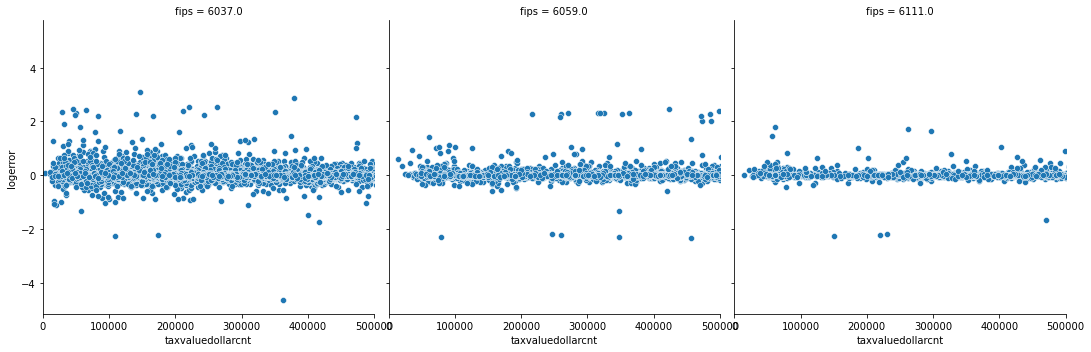

In [12]:
sns.relplot(data=train, x='taxvaluedollarcnt', y='logerror', col='fips')
plt.xlim(0,500000)
plt.show()

In [47]:
# homes with lower taxvalue dollar cnt have more log error than homes with above median taxvalue dollar cnt

#### Bonus: 
Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [48]:
train['logerror_abs'] = abs(train.logerror)

In [59]:
train.logerror_abs.std()

0.16586875937326218

In [90]:
logerror_abs_mean = train.logerror_abs.mean()
α = 0.05
above_below_abs = []

for z in train.regionidzip.unique().tolist():
    t, p = stats.ttest_1samp(train[train.regionidzip == z].logerror_abs, logerror_abs_mean)
    if p/2 < α:
        if t > 0:
            above_below_abs.append('above')
            print(f'{z} error is higher than expected error.')
        if t < 0:
            above_below_abs.append('below')
            print(f'{z} error is lower than expected error.')
    else:
        above_below_abs.append('no_diff')

96368.0 error is lower than expected error.
96475.0 error is lower than expected error.
97116.0 error is lower than expected error.
96239.0 error is lower than expected error.
97118.0 error is lower than expected error.
96369.0 error is lower than expected error.
96983.0 error is lower than expected error.
97035.0 error is lower than expected error.
97328.0 error is lower than expected error.
96242.0 error is lower than expected error.
96341.0 error is lower than expected error.
96978.0 error is higher than expected error.
97065.0 error is lower than expected error.
97089.0 error is lower than expected error.
97068.0 error is lower than expected error.
96020.0 error is higher than expected error.
97026.0 error is lower than expected error.
97027.0 error is lower than expected error.
97319.0 error is lower than expected error.
97043.0 error is lower than expected error.
96426.0 error is higher than expected error.
97091.0 error is lower than expected error.
96102.0 error is lower than e

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

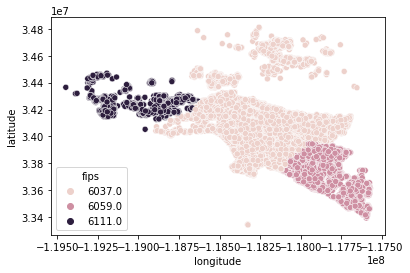

In [91]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

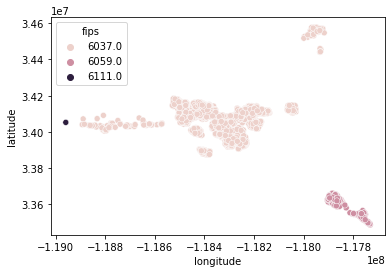

In [92]:
sns.scatterplot(data=train[train.regionidzip.isin(above_abs)], x='longitude', y='latitude', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

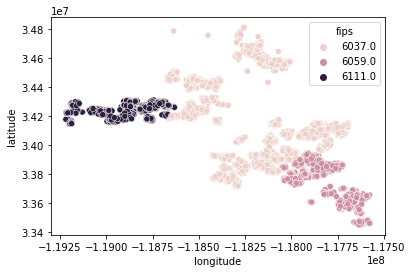

In [93]:
sns.scatterplot(data=train[train.regionidzip.isin(below_abs)], x='longitude', y='latitude', hue='fips')

In [19]:
logerror_mean = train.logerror.mean()
α = 0.05

In [20]:
above = []
below = []

for z in train.regionidzip.unique().tolist():
    t, p = stats.ttest_1samp(train[train.regionidzip == z].logerror, logerror_mean)
    if p/2 < α:
        if t > 0:
            above.append(z)
            print(f'{z} error is higher than expected error.')
        if t < 0:
            below.append(z)
            print(f'{z} error is lower than expected error.')
    else:
        continue

96008.0 error is lower than expected error.
96242.0 error is lower than expected error.
97089.0 error is lower than expected error.
97317.0 error is lower than expected error.
96020.0 error is lower than expected error.
96465.0 error is higher than expected error.
96326.0 error is lower than expected error.
96426.0 error is lower than expected error.
96325.0 error is higher than expected error.
96996.0 error is lower than expected error.
96102.0 error is lower than expected error.
96517.0 error is lower than expected error.
96124.0 error is lower than expected error.
96985.0 error is higher than expected error.
96387.0 error is higher than expected error.
96450.0 error is lower than expected error.
96186.0 error is higher than expected error.
96237.0 error is lower than expected error.
96046.0 error is lower than expected error.
96107.0 error is lower than expected error.
96478.0 error is lower than expected error.
96212.0 error is lower than expected error.
96190.0 error is lower than

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

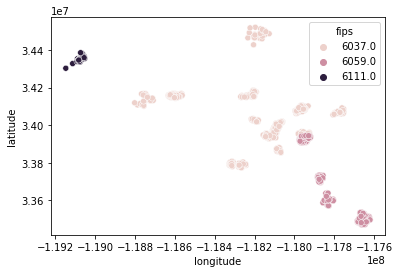

In [26]:
sns.scatterplot(data=train[train.regionidzip.isin(above)], x='longitude', y='latitude', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

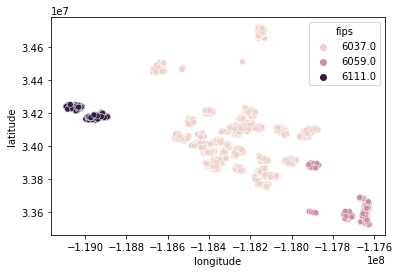

In [27]:
sns.scatterplot(data=train[train.regionidzip.isin(below)], x='longitude', y='latitude', hue='fips')

In [112]:
len(results_std), len(train.logerror)

(30584, 30329)

In [274]:
logerror_mean = train.logerror.mean()
logerror_std = train.logerror.std()
results_std = []

for entry in train.logerror:
    if entry < (logerror_mean - logerror_std*1):
        results_std.append('below')
    elif entry > (logerror_mean + logerror_std*1):
        results_std.append('above')
    else:
        results_std.append('within')
        
train['results'] = results_std

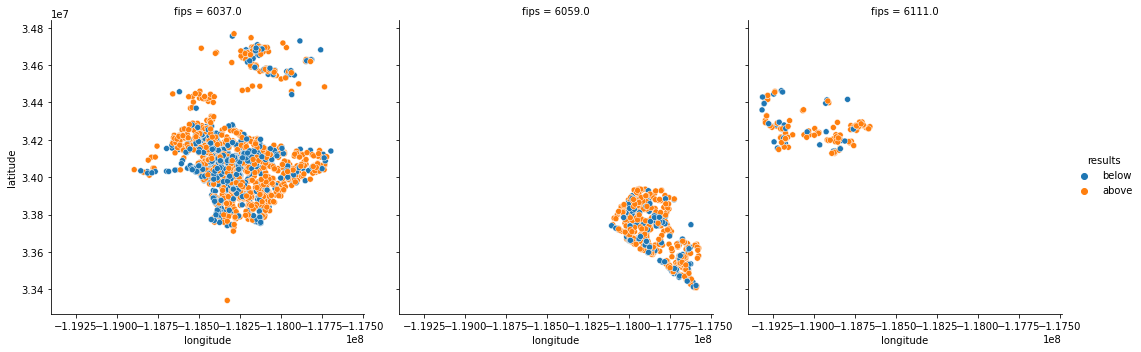

In [275]:
sns.relplot(data=train[train.results != 'within'], x='longitude', y='latitude', hue='results', col='fips')

In [190]:
train.columns

Index(['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'decktypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'fips', 'fireplacecnt', 'fullbathcnt', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'pooltypeid10',
       'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'threequarterbathnbr', 'yearbuilt',
       'fireplaceflag', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock',
       'logerror', 'transactiondate', 'typeconstructiondesc',
       'propertylandusedesc', 'logerror_abs', 'results'],
      dtype='object')

In [212]:
train['tax_ls'] = train.taxvaluedollarcnt/train.calculatedfinishedsquarefeet

In [278]:
train.results.value_counts()

within    27937
above      1426
below       966
Name: results, dtype: int64

In [279]:
train[train.results=='above'].regionidcity.value_counts()

12447.0     406
5534.0       47
46298.0      34
40227.0      31
25218.0      27
           ... 
52835.0       1
114828.0      1
30399.0       1
10734.0       1
18875.0       1
Name: regionidcity, Length: 152, dtype: int64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

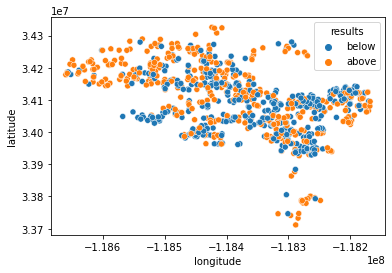

In [320]:
sns.scatterplot(data=train[(train.regionidcity == 12447)&(train.results != 'within')], y='latitude', x='longitude', hue='results')
# plt.ylim(3.32e7,3.5e7)
# plt.xlim(-1.195e8, -1.175e8)

In [299]:
nums = [col for col in train.columns if train[col].dtype != 'O']
cats = [col for col in train.columns if col not in nums]

In [310]:
below_df = train[(train.regionidcity == 12447)&(train.results == 'below')]
above_df = train[(train.regionidcity == 12447)&(train.results == 'above')]
within_df = train[(train.regionidcity == 12447)&(train.results == 'within')]

In [309]:
below_df[cats].describe().T

,count,unique,top,freq
propertycountylandusecode,418,5,0100,318
taxdelinquencyflag,418,2,N,377
transactiondate,418,149,2017-06-30,10
typeconstructiondesc,418,1,None,418
propertylandusedesc,418,1,Single Family Residential,418
results,418,1,below,418


In [316]:
below_df.propertycountylandusecode.value_counts()

0100    318
0101     91
010G      5
0103      3
0104      1
Name: propertycountylandusecode, dtype: int64

In [318]:
within_df.propertycountylandusecode.value_counts()

0100    4374
0101    1458
0104      46
010G      28
0103      23
0108      15
0113       2
0102       2
0133       1
0131       1
1110       1
Name: propertycountylandusecode, dtype: int64

In [317]:
above_df.propertycountylandusecode.value_counts()

0100    316
0101     84
0104      3
0109      2
0108      1
Name: propertycountylandusecode, dtype: int64

In [311]:
within_df[cats].describe().T

,count,unique,top,freq
propertycountylandusecode,5951,11,0100,4374
taxdelinquencyflag,5951,2,N,5655
transactiondate,5951,205,2017-06-30,86
typeconstructiondesc,5951,1,None,5951
propertylandusedesc,5951,1,Single Family Residential,5951
results,5951,1,within,5951


In [312]:
above_df[cats].describe().T

,count,unique,top,freq
propertycountylandusecode,406,5,0100,316
taxdelinquencyflag,406,2,N,367
transactiondate,406,160,2017-06-30,9
typeconstructiondesc,406,1,None,406
propertylandusedesc,406,1,Single Family Residential,406
results,406,1,above,406


In [298]:
train[(train.regionidcity == 12447)&(train.results == 'above')].describe().T

,count,mean,std,min,25%,50%,75%,max
basementsqft,406.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bathroomcnt,406.0,2.197044e+00,1.331699e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
bedroomcnt,406.0,3.174877e+00,1.195241e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+01
calculatedbathnbr,406.0,2.197044e+00,1.331699e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
decktypeid,406.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calculatedfinishedsquarefeet,406.0,1.920909e+03,1.324952e+03,3.600000e+02,1.150750e+03,1.498000e+03,2.307000e+03,1.068600e+04
finishedsquarefeet12,406.0,1.920909e+03,1.324952e+03,3.600000e+02,1.150750e+03,1.498000e+03,2.307000e+03,1.068600e+04
fips,406.0,6.037000e+03,0.000000e+00,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03
fireplacecnt,406.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fullbathcnt,406.0,2.197044e+00,1.331699e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

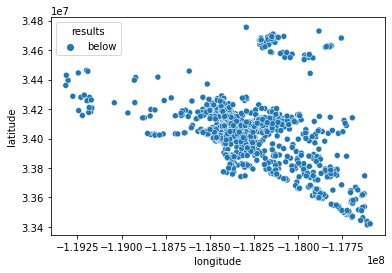

In [319]:
sns.scatterplot(data=train[(train.results == 'below')], y='latitude', x='longitude', hue='results')

In [289]:
train.regionidzip.unique()

array([96368., 96415., 96475., 97116., 96239., 97118., 97099., 96008.,
       96389., 96369., 96206., 96284., 96185., 96983., 97035., 97328.,
       96242., 96341., 96370., 96978., 96208., 97065., 97089., 97317.,
       97068., 96339., 96215., 96020., 97026., 97027., 96451., 97023.,
       97319., 96021., 97078., 96327., 96240., 97318., 97081., 96045.,
       97008., 97043., 96496., 96244., 96465., 96338., 97016., 96326.,
       96426., 97098., 96325., 96488., 97091., 96996., 96220., 96366.,
       96162., 96102., 97079., 96517., 96124., 96524., 97101., 96513.,
       96203., 96025., 96492., 96985., 96387., 96450., 96186., 96237.,
       96046., 96103., 96346., 96107., 96478., 96486., 96282., 96213.,
       96943., 96424., 96356., 96987., 96171., 96993., 96990., 96037.,
       96212., 96494., 96361., 96190., 96383., 96117., 96267., 96964.,
       97329., 96122., 96354., 96515., 96965., 96013., 97024., 96049.,
       96489., 96026., 96003., 96229., 96401., 96490., 96507., 96163.,
      

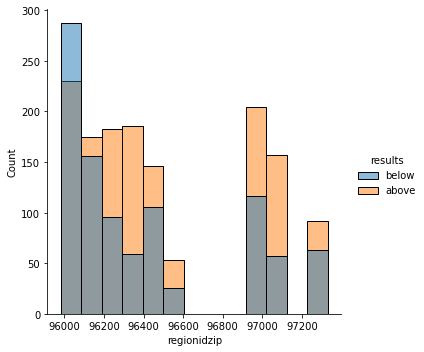

In [283]:
sns.displot(data=train[train.results != 'within'], x='regionidzip', hue='results', kind='hist')
# plt.xlim(96000,96200)
# plt.ylim(0,4000)
plt.show()

In [86]:
logerror_abs_mean

0.07249327267840006

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

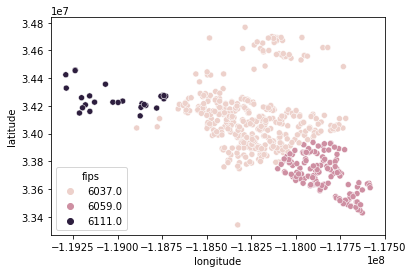

In [87]:
sns.scatterplot(data=train[train.logerror.isin(above_std)], x='longitude', y='latitude', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

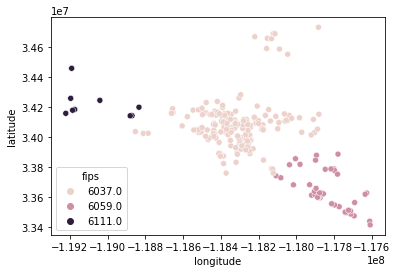

In [88]:
sns.scatterplot(data=train[train.logerror.isin(below_std)], x='longitude', y='latitude', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

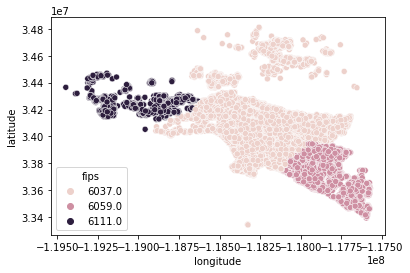

In [77]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='fips')

### FINDINGS
- For homes with logerror below 1.5std, 208/460 are in regionidcity 12447
- For homes with logerror above 1.5std, 228/857 are in regionidcity 12447